In [42]:
!pwd

/home/peter/proj/allestm-train/jupyter


In [43]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import numpy as np
import pandas as pd
import json
import pathlib
import math

from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve

import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()


#mpl.rcParams['figure.dpi'] = 300
#sns.set_style("ticks")

sns.set()
sns.set_style('whitegrid')
sns.set_context('paper')
sns.set_palette('Paired', 13)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


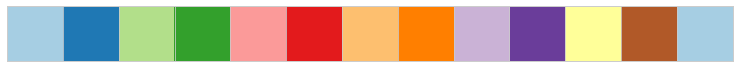

In [44]:
current_palette = sns.color_palette()
sns.palplot(current_palette)

# Config

In [45]:
dataset_name = 'depth'
kind = 'independent_test'#'test' / 'independent_test'
plot_dir = pathlib.Path('../plots/')
file_format = 'png'
savefig_args = {'dpi': 300, 'bbox_inches':'tight'}
two_col_fig_width = 7.5
one_col_fig_width = 3.5

method_mapping = [
    ['observed', 'Observed'],
    ['rf_', 'RF'],
    ['xgb_', 'GBM'],
    ['cnn_', 'conv'],
    ['dcnn_', 'dconv'],
    ['lstm_', 'LSTM'],
    ['blending', 'AllesTM'],
    ['profbval', 'PROFbval'],
    ['spinex', 'SPINE X'],
    ['anglor', 'ANGLOR'],
    ['predyflexy', 'PredyFlexy'],
    ['memsat', 'MEMSAT-SVM'],
    ['polyphobius', 'PolyPhobius'],
    ['prof', 'PROFphd'],
    ['psipred', 'PSIPRED'],
    ['scampi', 'SCAMPI'],
    ['spot1d', 'SPOT-1D']
]

# Raw data

In [46]:
conn = sqlite3.connect("../data.db")

In [47]:
raw_df = pd.read_sql_query(f"select * from raw_data join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) join proteins using (id)", conn)

In [48]:
raw_df.describe()

,resi,bfactor,phi,psi,acc_chain,acc_complex,tms_nr,re_nr,n_x,n_y,...,c_x,c_y,c_z,length,thickness,resolution,cov_total,cov_trimmed,num_tms,num_res
count,9119.000000,9119.000000,9119.000000,9119.000000,9119.000000,9119.000000,9119.000000,9119.000000,9119.000000,9119.000000,...,9119.000000,9119.000000,9119.000000,9119.000000,9119.000000,9119.000000,9119.000000,9119.0,9119.000000,9119.000000
mean,204.450707,71.901420,-1.162559,-0.111416,0.323908,0.251038,1.099463,-0.965128,1.503665,3.428989,...,1.487327,3.423585,-6.242691,409.901415,15.412995,2.785175,95.857906,100.0,7.523522,0.717732
std,155.431013,43.973387,0.672255,1.244709,0.264468,0.246289,3.206924,0.284673,18.818497,14.560095,...,18.825496,14.559098,29.080373,174.548703,1.228134,0.419614,3.490686,0.0,3.784249,1.050149
min,0.000000,5.890000,-3.131487,-3.140995,0.000000,0.000000,-1.000000,-1.000000,-55.810001,-38.498001,...,-55.222000,-37.893002,-95.398003,43.000000,13.600000,1.700000,85.082873,100.0,1.000000,0.000000
25%,76.000000,37.450000,-1.350834,-0.802789,0.072165,0.030488,-1.000000,-1.000000,-11.128000,-6.913500,...,-11.177000,-6.926500,-20.815000,268.000000,14.800000,2.500000,93.142145,100.0,6.000000,0.000000
50%,174.000000,64.410000,-1.144005,-0.646712,0.294416,0.176471,-1.000000,-1.000000,-0.229000,3.181000,...,-0.139000,3.160000,-4.927000,417.000000,15.000000,2.800000,95.966387,100.0,7.000000,0.000000
75%,303.000000,99.275000,-1.015406,-0.053161,0.524390,0.419118,3.000000,-1.000000,12.770500,13.455000,...,12.946500,13.496500,11.508500,557.000000,15.700000,3.000000,98.969072,100.0,11.000000,1.000000
max,746.000000,260.490000,3.131882,3.141438,1.000000,1.000000,13.000000,3.000000,82.396004,45.527000,...,80.091003,45.104000,92.435997,747.000000,18.400000,3.500000,100.000000,100.0,14.000000,4.000000


In [49]:
proteins_df = pd.read_sql_query(f"select * from (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a join proteins using (id)", conn)

In [50]:
proteins_df.describe()

,length,thickness,resolution,cov_total,cov_trimmed,num_tms,num_res
count,31.000000,31.000000,31.000000,31.000000,31.0,31.000000,31.000000
mean,294.161290,15.232258,2.727419,95.962736,100.0,5.838710,0.548387
std,187.566361,1.101631,0.446094,4.176741,0.0,4.091428,0.925156
min,43.000000,13.600000,1.700000,85.082873,100.0,1.000000,0.000000
25%,125.000000,14.750000,2.400000,93.467624,100.0,2.000000,0.000000
50%,268.000000,14.900000,2.800000,96.774194,100.0,6.000000,0.000000
75%,418.500000,15.650000,2.990000,100.000000,100.0,8.500000,1.000000
max,747.000000,18.400000,3.500000,100.000000,100.0,14.000000,4.000000


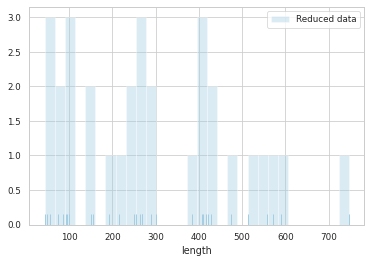

In [51]:
sns.distplot(proteins_df.length, kde=False, rug=True, bins=30, label="Reduced data")
#sns.distplot(pd.read_sql_query("select * from proteins", conn).length, kde=True, label="Original data")
plt.legend()

# Benchmark helper functions

## Measures

In [52]:
def exp2name(exp):
    for m, name in method_mapping:
        if exp.lower().startswith(m):
            return name
    return f'MISSING {exp}'

def exp2order(exp):
    for i, (m, name) in enumerate(method_mapping):
        if exp.lower().startswith(m):
            return i
    return f'MISSING {exp}'

In [53]:
def measures_cont(df, filename=None):
    measures = [pearsonr, mean_absolute_error, mean_squared_error, lambda x, y: math.sqrt(mean_squared_error(x, y))]
    measure_names = ['r', 'MAE', 'MSE', 'RMSE']
    obs = df[df.experiment == "observed"].val_0
    benchmarks = {}
    experiments = df[df.experiment != "observed"].experiment.unique()
    for experiment in sorted(experiments, key=exp2order):
        pred = df[df.experiment == experiment].val_0
        for i, measure in enumerate(measures):
            result = measure(obs, pred)
            if isinstance(result, list) or isinstance(result, tuple):
               
                if not measure_names[i] in benchmarks:
                    benchmarks[measure_names[i]] = []
                benchmarks[measure_names[i]].append(round(result[i], 2))
                #for i in range(len(result)):
                #    if not "{}_{}".format(measure.__name__, i) in benchmarks:
                #        benchmarks["{}_{}".format(measure.__name__, i)] = []
                #    benchmarks["{}_{}".format(measure.__name__, i)].append(round(result[i], 3))
            else:
                if not measure_names[i] in benchmarks:
                    benchmarks[measure_names[i]] = []
                benchmarks[measure_names[i]].append(round(result, 2))
    
    result = pd.DataFrame(benchmarks, index=[exp2name(x) for x in sorted(experiments, key=exp2order)])
    if filename is not None:
        result.to_csv(plot_dir / f'{dataset_name}_{kind}_{filename}.csv')
    return result.style.highlight_min(axis=0, color="yellow").highlight_max(axis=0, color="orange")
    #return pd.DataFrame(benchmarks, index=[exp2name(x) for x in experiments]).sort_values(by="MAE").style.highlight_min(axis=0, color="yellow").highlight_max(axis=0, color="orange")

In [54]:
def measures_bin(df, filename=None):
    measures = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef]
    measure_names = ['ACC', 'P', 'R', 'F1', 'AUC', 'MCC']
    obs = df[df.experiment == "observed"].val_0
    benchmarks = {measure: [] for measure in measure_names}
    experiments = df[df.experiment != "observed"].experiment.unique()
    for experiment in sorted(experiments, key=exp2order):
        pred = df[df.experiment == experiment].val_0.round()
        for i, measure in enumerate(measures):
            benchmarks[measure_names[i]].append(round(measure(obs, pred), 2))
    result = pd.DataFrame(benchmarks, index=[exp2name(x) for x in sorted(experiments, key=exp2order)])
    if filename is not None:
        result.to_csv(plot_dir / f'{dataset_name}_{kind}_{filename}.csv')
    return result.style.highlight_min(axis=0, color="yellow").highlight_max(axis=0, color="orange")
    #return pd.DataFrame(benchmarks, index=[exp2name(x) for x in experiments]).sort_values(by="ACC", ascending=False).style.highlight_min(axis=0, color="yellow").highlight_max(axis=0, color="orange")

In [55]:
def measures_cat(df, num_classes=3, class_names=None, filename=None):
    if class_names is None:
        class_names = [i for i in range(num_classes)]
        
    measures_all = [accuracy_score]
    measures_class = [precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef]
    measure_all_names = ['ACC']
    measure_names = ['P', 'R', 'F1', 'AUC', 'MCC']
    
    obs = df[df.experiment == "observed"][["val_{}".format(x) for x in range(num_classes)]]
    
    #benchmarks = {measure.__name__: [] for measure in measures_all + measures_class}
    benchmarks = {measure: [] for measure in measure_all_names}
    experiments = df[df.experiment != "observed"].experiment.unique()
    for experiment in sorted(experiments, key=exp2order):
        pred = df[df.experiment == experiment][["val_{}".format(x) for x in range(num_classes)]]
        pred_argmax = np.array(pred).argmax(axis=1)
        for i, measure in enumerate(measures_all):
            #logger.info(f'experiment: {experiment}, measure: {measure_all_names[i]}')
            benchmarks[measure_all_names[i]].append(round(measure(np.array(obs).argmax(axis=1), pred_argmax), 2))
        
        obs_rounded = np.array(obs)
        pred_rounded = np.zeros(pred.shape)
        for i, argmax in enumerate(pred_argmax):
            pred_rounded[i, argmax] = 1
           
        
            
            #class_results = []
        for i in range(num_classes):
            for m, measure in enumerate(measures_class):
                #logger.info(f'experiment: {experiment}, class: {i}, measure: {measure_names[m]}')
                if not "{} ({})".format(class_names[i], measure_names[m]) in benchmarks:
                    benchmarks["{} ({})".format(class_names[i], measure_names[m])] = []
                benchmarks["{} ({})".format(class_names[i], measure_names[m])].append(round(measure(obs_rounded[:, i], pred_rounded[:, i]), 2))
                #class_results.append(round(measure(obs_rounded[:, i], pred_rounded[:, i]), 3))
            #benchmarks[measure.__name__].append(class_results)
        
    result = pd.DataFrame(benchmarks, index=[exp2name(x) for x in sorted(experiments, key=exp2order)])
    if filename is not None:
        result.to_csv(plot_dir / f'{dataset_name}_{kind}_{filename}.csv')
    return result.style.highlight_min(axis=0, color="yellow").highlight_max(axis=0, color="orange")
    #return pd.DataFrame(benchmarks, index=[exp2name(x) for x in experiments]).sort_values(by="ACC", ascending=False).style.highlight_min(axis=0, color="yellow").highlight_max(axis=0, color="orange")

<h2>Plots</h2>

In [56]:
def plots_cont(df, xlab, ylab, filename=None, hist=False, kde=True, reverse=False, filters=None):
    fig, ax = plt.subplots(1, 1, figsize=(one_col_fig_width, one_col_fig_width))
    #min_val = df.val_0.min()
    #max_val = df.val_0.max()
    #axs[1].set(xlim=(min_val, max_val), ylim=(min_val, max_val))
    for experiment in sorted(df.experiment.unique(), reverse=reverse, key=exp2order):
        color = None
        if filters:
            m = [v for k, v in filters.items() if experiment.startswith(k)]
            if not m:
                continue
            else:
                color = m[0]
                print(f'color is {color}')
                
        kde_kws = {}
        
        if experiment == "observed":
            #hist = True
            color='black'
            kde_kws["lw"] = 4
        else:
            pass
            #sns.kdeplot(df[df.experiment == 'observed'].val_0, df[df.experiment == experiment].val_0, label=experiment, ax=axs[1])
            #sns.regplot(df[df.experiment == 'observed'].val_0, df[df.experiment == experiment].val_0, label=experiment, ax=axs[1], scatter=False)
        
        if hist:
            palette = {'Observed': 'lightgray', 'RF': 'gray', 'AllesTM': 'black'}
            sns.distplot(df[df.experiment == experiment].val_0, label=exp2name(experiment), hist=hist, kde=kde, color=color, ax=ax, kde_kws=kde_kws, hist_kws=dict(alpha=0.5, color=palette[exp2name(experiment)]))
        else:
            sns.distplot(df[df.experiment == experiment].val_0, label=exp2name(experiment), hist=hist, kde=kde, color=color, ax=ax, kde_kws=kde_kws, hist_kws=dict(alpha=0.3))
    ax.set(xlabel=xlab, ylabel=ylab)
    ax.legend(frameon=True, facecolor='white', framealpha=0.8)
    #axs[1].set(xlabel='Observed', ylabel='Predicted')
    #axs[1].legend()
    if filename is not None:
        fig.savefig(plot_dir / f'{dataset_name}_{kind}_{filename}.{file_format}', **savefig_args)

In [57]:
def plots_bin(obs_df, dfs, filename=None):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(two_col_fig_width, two_col_fig_width/2)
    for a in ax:
        a.set_xlim([0, 1])
        a.set_ylim([0, 1])
    
    obs = obs_df[obs_df.experiment == "observed"].val_0
    
    for name, df in dfs.items():
        for experiment in sorted(df[df.experiment != "observed"].experiment.unique(), key=exp2order):
            pr = precision_recall_curve(obs, df[df.experiment == experiment].val_0)
            ax[0].plot(pr[1], pr[0], label=exp2name(experiment))

            roc = roc_curve(obs, df[df.experiment == experiment].val_0)
            ax[1].plot(roc[0], roc[1], label=exp2name(experiment))

    ax[0].set(xlabel="Recall", ylabel="Precision")
    #ax[0].legend()
    ax[1].set(xlabel="FPR or (1 - specificity)", ylabel="TPR or sensitivity")
    ax[1].legend(frameon=True, facecolor='white', framealpha=0.8)
    if filename is not None:
        fig.savefig(plot_dir / f'{dataset_name}_{kind}_{filename}.{file_format}', **savefig_args)

In [58]:
def plots_cat(obs_df, dfs, num_classes=3, filename=None, class_names=None):
    fig, ax = plt.subplots(num_classes, 2)
    fig.set_size_inches(two_col_fig_width, two_col_fig_width / 2 * num_classes)
    for a in ax:
        for b in a:
            b.set_xlim([0, 1])
            b.set_ylim([0, 1])
            
    if class_names is None:
        class_names = [str(i) for i in range(num_classes)]
    
    obs_rounded = obs_df[obs_df.experiment == "observed"][["val_{}".format(x) for x in range(num_classes)]].values
    
    for name, df in dfs.items():
        for experiment in sorted(df[df.experiment != "observed"].experiment.unique(), key=exp2order):
            pred = df[df.experiment == experiment][["val_{}".format(x) for x in range(num_classes)]]
            pred_argmax = np.array(pred).argmax(axis=1)
            
            pred_rounded = pred.values
            #pred_rounded = np.zeros(pred.shape)
            #for i, argmax in enumerate(pred_argmax):
            #    pred_rounded[i, argmax] = 1
                
            for i in range(num_classes):
                pr = precision_recall_curve(obs_rounded[:, i], pred_rounded[:, i])
                ax[i][0].plot(pr[1], pr[0], label=exp2name(experiment))

                roc = roc_curve(obs_rounded[:, i], pred_rounded[:, i])
                ax[i][1].plot(roc[0], roc[1], label=exp2name(experiment))

                ax[i][0].set(xlabel="Recall", ylabel="Precision")
                ax[i][1].set(xlabel="FPR or (1 - specificity)", ylabel="TPR or sensitivity")
                #ax[i][0].legend()
                if i == 0:
                    ax[i][1].legend(frameon=True, facecolor='white', framealpha=0.8)
                    
                ax[i][0].annotate(class_names[i], (0.1, 0.1), horizontalalignment='center', verticalalignment='center', fontsize='xx-large')
                
    if filename is not None:
        fig.savefig(plot_dir / f'{dataset_name}_{kind}_{filename}.{file_format}', **savefig_args)

<h1>Bfactors</h1>

<h2>Bfactors continuous</h2>

In [59]:
bfactors_cont = pd.read_sql_query(f"select * from mllib_features_continuous_bfactors join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [60]:
bfactors_cont.groupby("experiment").describe()

resi                                     \
                                  count        mean         std  min   25%   
experiment                                                                   
blending_bfactors_cont_IND_TEST  9119.0  204.450707  155.431013  0.0  76.0   
cnn_domain_bfactors_IND_TEST     9119.0  204.450707  155.431013  0.0  76.0   
dcnn_domain_bfactors_IND_TEST    9119.0  204.450707  155.431013  0.0  76.0   
lstm_domain_bfactors_IND_TEST    9119.0  204.450707  155.431013  0.0  76.0   
observed                         9119.0  204.450707  155.431013  0.0  76.0   
predyflexy                       9119.0  204.450707  155.431013  0.0  76.0   
profbval_bnorm                   9119.0  204.450707  155.431013  0.0  76.0   
rf_bfactors_cont_IND_TEST        9119.0  204.450707  155.431013  0.0  76.0   
xgb_bfactors_cont_IND_TEST       9119.0  204.450707  155.431013  0.0  76.0   

                                                       val_0                \
                                   50%    75%    max   count          mean   
experiment                                                                   
blending_bfactors_cont_IND_TEST  174.0  303.0  746.0  9119.0 -7.735799e-03   
cnn_domain_bfactors_IND_TEST     174.0  303.0  746.0  9119.0 -1.532388e-01   
dcnn_domain_bfactors_IND_TEST    174.0  303.0  746.0  9119.0 -1.282274e-01   
lstm_domain_bfactors_IND_TEST    174.0  303.0  746.0  9119.0 -1.333781e-01   
observed                         174.0  303.0  746.0  9119.0 -2.883000e-17   
predyflexy                       174.0  303.0  746.0  9119.0  1.707874e-01   
profbval_bnorm                   174.0  303.0  746.0  9119.0  1.206163e-02   
rf_bfactors_cont_IND_TEST        174.0  303.0  746.0  9119.0  2.086844e-02   
xgb_bfactors_cont_IND_TEST       174.0  303.0  746.0  9119.0 -2.955301e-03   

                                                                         \
                                      std       min       25%       50%   
experiment                                                                
blending_bfactors_cont_IND_TEST  0.479217 -0.759318 -0.376634 -0.133195   
cnn_domain_bfactors_IND_TEST     0.433567 -0.868519 -0.467451 -0.268236   
dcnn_domain_bfactors_IND_TEST    0.465115 -0.865347 -0.484678 -0.251793   
lstm_domain_bfactors_IND_TEST    0.418023 -0.804733 -0.454426 -0.245034   
observed                         1.000055 -2.373485 -0.682823 -0.213858   
predyflexy                       0.415221 -0.696000 -0.185000  0.120000   
profbval_bnorm                   0.876200 -2.530000 -0.670000 -0.100000   
rf_bfactors_cont_IND_TEST        0.399447 -0.675185 -0.320166 -0.058063   
xgb_bfactors_cont_IND_TEST       0.448392 -0.774225 -0.360835 -0.095736   

                                                      
                                      75%        max  
experiment                                            
blending_bfactors_cont_IND_TEST  0.261611   2.316440  
cnn_domain_bfactors_IND_TEST     0.050474   2.124419  
dcnn_domain_bfactors_IND_TEST    0.127177   1.892927  
lstm_domain_bfactors_IND_TEST    0.109749   1.958333  
observed                         0.433227  11.068478  
predyflexy                       0.504000   1.521000  
profbval_bnorm                   0.600000   4.750000  
rf_bfactors_cont_IND_TEST        0.299977   2.050862  
xgb_bfactors_cont_IND_TEST       0.281561   2.442103

<h3>Benchmark measures</h3>

In [61]:
measures_cont(bfactors_cont, filename='bfactors_cont')

,r,MAE,MSE,RMSE
RF,0.440000,0.670000,0.810000,0.900000
GBM,0.470000,0.650000,0.780000,0.890000
conv,0.500000,0.630000,0.780000,0.880000
dconv,0.500000,0.630000,0.770000,0.880000
LSTM,0.500000,0.630000,0.780000,0.880000
AllesTM,0.510000,0.630000,0.750000,0.860000
PROFbval,0.400000,0.780000,1.070000,1.040000
PredyFlexy,0.130000,0.800000,1.090000,1.040000


<h3>Benchmark plots</h3>

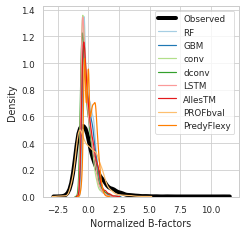

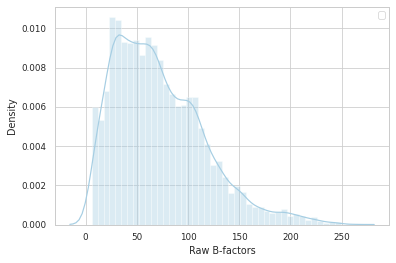

In [62]:
plots_cont(bfactors_cont, "Normalized B-factors", "Density", filename='bfactors_cont')

fig, ax = plt.subplots()
#fig.set_size_inches(11.7, 8.27)
sns.distplot(raw_df.bfactor, ax=ax)
ax.set(xlabel="Raw B-factors", ylabel="Density")
ax.legend()

<h2>Bfactors binary</h2>

In [63]:
bfactors_bin = pd.read_sql_query(f"select * from mllib_features_binary_bfactors join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [64]:
bfactors_bin.groupby("experiment").describe()

resi                                     \
                                 count        mean         std  min   25%   
experiment                                                                  
blending_bfactors_bin_IND_TEST  9119.0  204.450707  155.431013  0.0  76.0   
cnn_domain_bfactors_IND_TEST    9119.0  204.450707  155.431013  0.0  76.0   
dcnn_domain_bfactors_IND_TEST   9119.0  204.450707  155.431013  0.0  76.0   
lstm_domain_bfactors_IND_TEST   9119.0  204.450707  155.431013  0.0  76.0   
observed                        9119.0  204.450707  155.431013  0.0  76.0   
profbval_strict                 9119.0  204.450707  155.431013  0.0  76.0   
rf_bfactors_bin_IND_TEST        9119.0  204.450707  155.431013  0.0  76.0   
xgb_bfactors_bin_IND_TEST       9119.0  204.450707  155.431013  0.0  76.0   

                                                      val_0            \
                                  50%    75%    max   count      mean   
experiment                                                              
blending_bfactors_bin_IND_TEST  174.0  303.0  746.0  9119.0  0.393814   
cnn_domain_bfactors_IND_TEST    174.0  303.0  746.0  9119.0  0.386951   
dcnn_domain_bfactors_IND_TEST   174.0  303.0  746.0  9119.0  0.397690   
lstm_domain_bfactors_IND_TEST   174.0  303.0  746.0  9119.0  0.383937   
observed                        174.0  303.0  746.0  9119.0  0.383595   
profbval_strict                 174.0  303.0  746.0  9119.0  0.107249   
rf_bfactors_bin_IND_TEST        174.0  303.0  746.0  9119.0  0.397103   
xgb_bfactors_bin_IND_TEST       174.0  303.0  746.0  9119.0  0.370638   

                                                                        \
                                     std       min       25%       50%   
experiment                                                               
blending_bfactors_bin_IND_TEST  0.190914  0.133883  0.226693  0.345966   
cnn_domain_bfactors_IND_TEST    0.190750  0.067226  0.228611  0.350454   
dcnn_domain_bfactors_IND_TEST   0.213568  0.067157  0.212335  0.349745   
lstm_domain_bfactors_IND_TEST   0.198819  0.059241  0.213028  0.350469   
observed                        0.486288  0.000000  0.000000  0.000000   
profbval_strict                 0.309446  0.000000  0.000000  0.000000   
rf_bfactors_bin_IND_TEST        0.164196  0.100980  0.257156  0.381966   
xgb_bfactors_bin_IND_TEST       0.214125  0.038722  0.186186  0.326661   

                                                    
                                     75%       max  
experiment                                          
blending_bfactors_bin_IND_TEST  0.541193  0.874062  
cnn_domain_bfactors_IND_TEST    0.519032  0.939388  
dcnn_domain_bfactors_IND_TEST   0.559743  0.944179  
lstm_domain_bfactors_IND_TEST   0.536434  0.928270  
observed                        1.000000  1.000000  
profbval_strict                 0.000000  1.000000  
rf_bfactors_bin_IND_TEST        0.519963  0.894289  
xgb_bfactors_bin_IND_TEST       0.534911  0.947724

<h3>Benchmark measures</h3>

In [65]:
measures_bin(bfactors_bin, filename='bfactors_bin')

,ACC,P,R,F1,AUC,MCC
RF,0.680000,0.620000,0.460000,0.530000,0.640000,0.310000
GBM,0.690000,0.630000,0.470000,0.540000,0.650000,0.320000
conv,0.700000,0.650000,0.460000,0.540000,0.650000,0.340000
dconv,0.700000,0.630000,0.520000,0.570000,0.660000,0.340000
LSTM,0.700000,0.640000,0.480000,0.550000,0.660000,0.330000
AllesTM,0.700000,0.640000,0.490000,0.560000,0.660000,0.340000
PROFbval,0.650000,0.660000,0.190000,0.290000,0.560000,0.200000


<h3>Benchmark curves</h3>

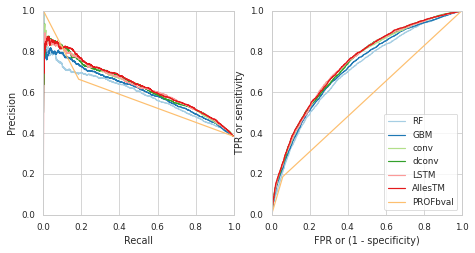

In [66]:
plots_bin(bfactors_bin, {"bin": bfactors_bin}, filename='bfactors_bin')

# Bfactors - TMS

<h2>Bfactors continuous</h2>

In [67]:
bfactors_cont_tms = pd.read_sql_query(f"select p.experiment, p.id, p.resi, p.val_0 from mllib_features_continuous_bfactors as p join raw_data using (id, resi) join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where topo='T' and experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [68]:
bfactors_cont_tms.groupby("experiment").describe()

resi                                      \
                                  count        mean         std  min    25%   
experiment                                                                    
blending_bfactors_cont_IND_TEST  4010.0  170.450125  132.154549  0.0  61.25   
cnn_domain_bfactors_IND_TEST     4010.0  170.450125  132.154549  0.0  61.25   
dcnn_domain_bfactors_IND_TEST    4010.0  170.450125  132.154549  0.0  61.25   
lstm_domain_bfactors_IND_TEST    4010.0  170.450125  132.154549  0.0  61.25   
observed                         4010.0  170.450125  132.154549  0.0  61.25   
predyflexy                       4010.0  170.450125  132.154549  0.0  61.25   
profbval_bnorm                   4010.0  170.450125  132.154549  0.0  61.25   
rf_bfactors_cont_IND_TEST        4010.0  170.450125  132.154549  0.0  61.25   
xgb_bfactors_cont_IND_TEST       4010.0  170.450125  132.154549  0.0  61.25   

                                                       val_0            \
                                   50%    75%    max   count      mean   
experiment                                                               
blending_bfactors_cont_IND_TEST  139.0  266.0  557.0  4010.0 -0.232748   
cnn_domain_bfactors_IND_TEST     139.0  266.0  557.0  4010.0 -0.329972   
dcnn_domain_bfactors_IND_TEST    139.0  266.0  557.0  4010.0 -0.351357   
lstm_domain_bfactors_IND_TEST    139.0  266.0  557.0  4010.0 -0.323596   
observed                         139.0  266.0  557.0  4010.0 -0.251624   
predyflexy                       139.0  266.0  557.0  4010.0  0.042768   
profbval_bnorm                   139.0  266.0  557.0  4010.0 -0.604633   
rf_bfactors_cont_IND_TEST        139.0  266.0  557.0  4010.0 -0.240455   
xgb_bfactors_cont_IND_TEST       139.0  266.0  557.0  4010.0 -0.263100   

                                                                         \
                                      std       min       25%       50%   
experiment                                                                
blending_bfactors_cont_IND_TEST  0.318806 -0.744997 -0.447721 -0.315988   
cnn_domain_bfactors_IND_TEST     0.294295 -0.868519 -0.520142 -0.407451   
dcnn_domain_bfactors_IND_TEST    0.304113 -0.865347 -0.556021 -0.428061   
lstm_domain_bfactors_IND_TEST    0.279914 -0.800477 -0.512504 -0.399880   
observed                         0.751957 -2.373485 -0.758404 -0.372057   
predyflexy                       0.393973 -0.651000 -0.317000 -0.044500   
profbval_bnorm                   0.540517 -2.530000 -0.930000 -0.680000   
rf_bfactors_cont_IND_TEST        0.246622 -0.675185 -0.396383 -0.316965   
xgb_bfactors_cont_IND_TEST       0.289028 -0.761144 -0.451076 -0.337828   

                                                     
                                      75%       max  
experiment                                           
blending_bfactors_cont_IND_TEST -0.110488  1.879405  
cnn_domain_bfactors_IND_TEST    -0.216365  1.723061  
dcnn_domain_bfactors_IND_TEST   -0.235513  1.501179  
lstm_domain_bfactors_IND_TEST   -0.215755  1.623132  
observed                         0.090656  4.600515  
predyflexy                       0.339000  1.494000  
profbval_bnorm                  -0.350000  4.590000  
rf_bfactors_cont_IND_TEST       -0.159421  1.913024  
xgb_bfactors_cont_IND_TEST      -0.152505  2.272868

<h3>Benchmark measures</h3>

In [69]:
measures_cont(bfactors_cont_tms, filename='bfactors_cont_tms')

,r,MAE,MSE,RMSE
RF,0.300000,0.530000,0.510000,0.720000
GBM,0.320000,0.520000,0.510000,0.710000
conv,0.360000,0.510000,0.500000,0.710000
dconv,0.370000,0.510000,0.500000,0.710000
LSTM,0.360000,0.510000,0.500000,0.710000
AllesTM,0.370000,0.520000,0.490000,0.700000
PROFbval,0.120000,0.660000,0.880000,0.940000
PredyFlexy,0.010000,0.700000,0.800000,0.900000


<h3>Benchmark plots</h3>

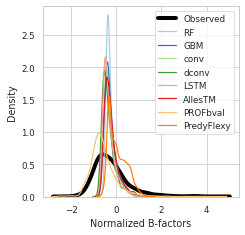

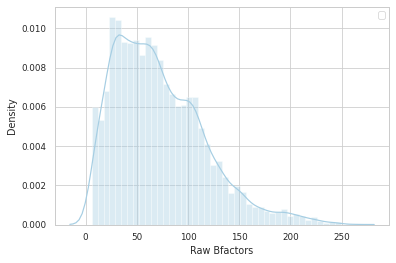

In [70]:
plots_cont(bfactors_cont_tms, "Normalized B-factors", "Density", filename='bfactors_cont_tms')

fig, ax = plt.subplots()
#fig.set_size_inches(11.7, 8.27)
sns.distplot(raw_df.bfactor, ax=ax)
ax.set(xlabel="Raw Bfactors", ylabel="Density")
ax.legend()

<h2>Bfactors binary</h2>

In [71]:
bfactors_bin_tms = pd.read_sql_query(f"select p.experiment, p.id, p.resi, p.val_0 from mllib_features_binary_bfactors as p join raw_data using (id, resi) join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where topo='T' and experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [72]:
bfactors_bin_tms.groupby("experiment").describe()

resi                                      \
                                 count        mean         std  min    25%   
experiment                                                                   
blending_bfactors_bin_IND_TEST  4010.0  170.450125  132.154549  0.0  61.25   
cnn_domain_bfactors_IND_TEST    4010.0  170.450125  132.154549  0.0  61.25   
dcnn_domain_bfactors_IND_TEST   4010.0  170.450125  132.154549  0.0  61.25   
lstm_domain_bfactors_IND_TEST   4010.0  170.450125  132.154549  0.0  61.25   
observed                        4010.0  170.450125  132.154549  0.0  61.25   
profbval_strict                 4010.0  170.450125  132.154549  0.0  61.25   
rf_bfactors_bin_IND_TEST        4010.0  170.450125  132.154549  0.0  61.25   
xgb_bfactors_bin_IND_TEST       4010.0  170.450125  132.154549  0.0  61.25   

                                                      val_0            \
                                  50%    75%    max   count      mean   
experiment                                                              
blending_bfactors_bin_IND_TEST  139.0  266.0  557.0  4010.0  0.298158   
cnn_domain_bfactors_IND_TEST    139.0  266.0  557.0  4010.0  0.297942   
dcnn_domain_bfactors_IND_TEST   139.0  266.0  557.0  4010.0  0.285640   
lstm_domain_bfactors_IND_TEST   139.0  266.0  557.0  4010.0  0.287767   
observed                        139.0  266.0  557.0  4010.0  0.276808   
profbval_strict                 139.0  266.0  557.0  4010.0  0.003990   
rf_bfactors_bin_IND_TEST        139.0  266.0  557.0  4010.0  0.281339   
xgb_bfactors_bin_IND_TEST       139.0  266.0  557.0  4010.0  0.248596   

                                                                        \
                                     std       min       25%       50%   
experiment                                                               
blending_bfactors_bin_IND_TEST  0.139901  0.136756  0.196518  0.248747   
cnn_domain_bfactors_IND_TEST    0.145510  0.067226  0.192200  0.256053   
dcnn_domain_bfactors_IND_TEST   0.154632  0.078292  0.173005  0.238975   
lstm_domain_bfactors_IND_TEST   0.152315  0.059241  0.173307  0.244956   
observed                        0.447477  0.000000  0.000000  0.000000   
profbval_strict                 0.063048  0.000000  0.000000  0.000000   
rf_bfactors_bin_IND_TEST        0.111949  0.100980  0.201602  0.255528   
xgb_bfactors_bin_IND_TEST       0.150090  0.041006  0.140574  0.205212   

                                                    
                                     75%       max  
experiment                                          
blending_bfactors_bin_IND_TEST  0.357206  0.838584  
cnn_domain_bfactors_IND_TEST    0.370707  0.903294  
dcnn_domain_bfactors_IND_TEST   0.355563  0.889444  
lstm_domain_bfactors_IND_TEST   0.368073  0.871449  
observed                        1.000000  1.000000  
profbval_strict                 0.000000  1.000000  
rf_bfactors_bin_IND_TEST        0.334572  0.841996  
xgb_bfactors_bin_IND_TEST       0.316704  0.945988

<h3>Benchmark measures</h3>

In [73]:
measures_bin(bfactors_bin_tms, filename='bfactors_bin_tms')

,ACC,P,R,F1,AUC,MCC
RF,0.730000,0.580000,0.120000,0.190000,0.540000,0.170000
GBM,0.730000,0.550000,0.170000,0.260000,0.560000,0.180000
conv,0.730000,0.560000,0.200000,0.300000,0.570000,0.210000
dconv,0.730000,0.540000,0.220000,0.310000,0.570000,0.210000
LSTM,0.730000,0.540000,0.220000,0.310000,0.570000,0.210000
AllesTM,0.730000,0.550000,0.220000,0.310000,0.570000,0.210000
PROFbval,0.720000,0.620000,0.010000,0.020000,0.500000,0.050000


<h3>Benchmark curves</h3>

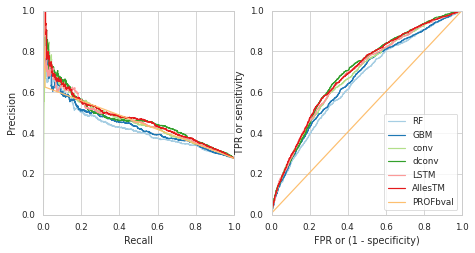

In [74]:
plots_bin(bfactors_bin_tms, {"bin": bfactors_bin_tms}, filename='bfactors_bin_tms')

<h1>Z-coordinates</h1>

<h2>Z-coordinates continuous</h2>

In [75]:
zcoords_cont = pd.read_sql_query(f"select * from mllib_features_continuous_ZCoordinates join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [76]:
zcoords_cont.groupby("experiment").describe()

resi                                     \
                                 count        mean         std  min   25%   
experiment                                                                  
blending_zcoords_cont_IND_TEST  9119.0  204.450707  155.431013  0.0  76.0   
cnn_domain_zcoords_IND_TEST     9119.0  204.450707  155.431013  0.0  76.0   
dcnn_domain_zcoords_IND_TEST    9119.0  204.450707  155.431013  0.0  76.0   
lstm_domain_zcoords_IND_TEST    9119.0  204.450707  155.431013  0.0  76.0   
observed                        9119.0  204.450707  155.431013  0.0  76.0   
rf_zcoords_cont_IND_TEST        9119.0  204.450707  155.431013  0.0  76.0   
xgb_zcoords_cont_IND_TEST       9119.0  204.450707  155.431013  0.0  76.0   

                                                      val_0            \
                                  50%    75%    max   count      mean   
experiment                                                              
blending_zcoords_cont_IND_TEST  174.0  303.0  746.0  9119.0 -3.411381   
cnn_domain_zcoords_IND_TEST     174.0  303.0  746.0  9119.0 -2.615882   
dcnn_domain_zcoords_IND_TEST    174.0  303.0  746.0  9119.0 -3.118907   
lstm_domain_zcoords_IND_TEST    174.0  303.0  746.0  9119.0 -3.556133   
observed                        174.0  303.0  746.0  9119.0 -3.528431   
rf_zcoords_cont_IND_TEST        174.0  303.0  746.0  9119.0 -2.436911   
xgb_zcoords_cont_IND_TEST       174.0  303.0  746.0  9119.0 -2.181585   

                                                                           \
                                      std        min        25%       50%   
experiment                                                                  
blending_zcoords_cont_IND_TEST  15.312767 -25.161315 -18.497631 -3.957815   
cnn_domain_zcoords_IND_TEST     14.438066 -25.000000 -15.856489 -2.223068   
dcnn_domain_zcoords_IND_TEST    14.401329 -25.000000 -16.723899 -3.595061   
lstm_domain_zcoords_IND_TEST    15.321014 -24.603902 -18.669107 -4.000594   
observed                        17.203373 -25.000000 -20.734500 -4.707000   
rf_zcoords_cont_IND_TEST         8.855791 -24.068673  -8.600317 -2.093967   
xgb_zcoords_cont_IND_TEST       10.457654 -23.873554 -10.650663 -2.007844   

                                                      
                                      75%        max  
experiment                                            
blending_zcoords_cont_IND_TEST  10.099669  25.362895  
cnn_domain_zcoords_IND_TEST      9.391068  24.669275  
dcnn_domain_zcoords_IND_TEST     9.354854  25.000000  
lstm_domain_zcoords_IND_TEST     9.847726  24.772790  
observed                        11.403500  25.000000  
rf_zcoords_cont_IND_TEST         2.990508  22.272620  
xgb_zcoords_cont_IND_TEST        4.756929  24.044033

<h3>Benchmark measures</h3>

In [77]:
measures_cont(zcoords_cont, filename='zcoords_cont')

,r,MAE,MSE,RMSE
RF,0.790000,9.100000,134.690000,11.610000
GBM,0.840000,7.820000,106.050000,10.300000
conv,0.870000,5.180000,71.300000,8.440000
dconv,0.920000,4.450000,47.960000,6.930000
LSTM,0.930000,3.710000,40.840000,6.390000
AllesTM,0.930000,3.720000,39.960000,6.320000


<h3>Benchmark plots</h3>

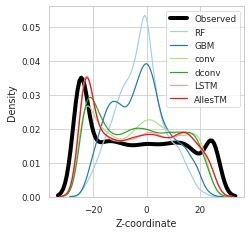

In [78]:
plots_cont(zcoords_cont, "Z-coordinate", "Density", filename='zcoords_cont')

color is black
color is lightblue
color is red


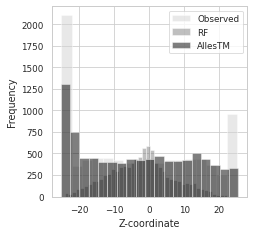

In [79]:
plots_cont(zcoords_cont, "Z-coordinate", "Frequency", filename='hist_zcoords_cont', hist=True, kde=False, reverse=False, filters={'observed': 'black', 'rf_': 'lightblue', 'blending_': 'red'})

# Topology

In [80]:
zcoords_cat = pd.read_sql_query(f"select * from mllib_features_categorical_Topology join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [81]:
zcoords_cat.groupby("experiment").describe()

resi                                     \
                               count        mean         std  min   25%   
experiment                                                                
blending_topo_IND_TEST        9119.0  204.450707  155.431013  0.0  76.0   
cnn_domain_zcoords_IND_TEST   9119.0  204.450707  155.431013  0.0  76.0   
dcnn_domain_zcoords_IND_TEST  9119.0  204.450707  155.431013  0.0  76.0   
lstm_domain_zcoords_IND_TEST  9119.0  204.450707  155.431013  0.0  76.0   
memsat_svm                    9119.0  204.450707  155.431013  0.0  76.0   
observed                      9119.0  204.450707  155.431013  0.0  76.0   
polyphobius                   9119.0  204.450707  155.431013  0.0  76.0   
rf_topo_IND_TEST              9119.0  204.450707  155.431013  0.0  76.0   
scampi                        9119.0  204.450707  155.431013  0.0  76.0   
xgb_topo_IND_TEST             9119.0  204.450707  155.431013  0.0  76.0   

                                                    val_0            ...  \
                                50%    75%    max   count      mean  ...   
experiment                                                           ...   
blending_topo_IND_TEST        174.0  303.0  746.0  9119.0  0.335855  ...   
cnn_domain_zcoords_IND_TEST   174.0  303.0  746.0  9119.0  0.319371  ...   
dcnn_domain_zcoords_IND_TEST  174.0  303.0  746.0  9119.0  0.324100  ...   
lstm_domain_zcoords_IND_TEST  174.0  303.0  746.0  9119.0  0.339443  ...   
memsat_svm                    174.0  303.0  746.0  9119.0  0.369997  ...   
observed                      174.0  303.0  746.0  9119.0  0.343568  ...   
polyphobius                   174.0  303.0  746.0  9119.0  0.302884  ...   
rf_topo_IND_TEST              174.0  303.0  746.0  9119.0  0.322587  ...   
scampi                        174.0  303.0  746.0  9119.0  0.361662  ...   
xgb_topo_IND_TEST             174.0  303.0  746.0  9119.0  0.335318  ...   

                                 val_2             val_3                      \
                                   75%       max   count      mean       std   
experiment                                                                     
blending_topo_IND_TEST        0.167226  0.968358  9119.0  0.031637  0.063047   
cnn_domain_zcoords_IND_TEST   0.345495  0.985136  9119.0  0.021545  0.027422   
dcnn_domain_zcoords_IND_TEST  0.296829  0.988478  9119.0  0.025007  0.045414   
lstm_domain_zcoords_IND_TEST  0.208575  0.993956  9119.0  0.027842  0.057174   
memsat_svm                    0.000000  1.000000  9119.0  0.003948  0.062711   
observed                      0.000000  1.000000  9119.0  0.019739  0.139110   
polyphobius                   1.000000  1.000000  9119.0  0.000000  0.000000   
rf_topo_IND_TEST              0.307000  0.880536  9119.0  0.029228  0.025522   
scampi                        0.000000  1.000000  9119.0  0.000000  0.000000   
xgb_topo_IND_TEST             0.236423  0.993539  9119.0  0.014102  0.022381   

                                                                                
                                   min       25%       50%       75%       max  
experiment                                                                      
blending_topo_IND_TEST        0.006444  0.013387  0.018692  0.023086  0.738655  
cnn_domain_zcoords_IND_TEST   0.000069  0.004327  0.011844  0.028010  0.235160  
dcnn_domain_zcoords_IND_TEST  0.000268  0.003984  0.010306  0.027685  0.514985  
lstm_domain_zcoords_IND_TEST  0.000780  0.006055  0.011467  0.023664  0.572984  
memsat_svm                    0.000000  0.000000  0.000000  0.000000  1.000000  
observed                      0.000000  0.000000  0.000000  0.000000  1.000000  
polyphobius                   0.000000  0.000000  0.000000  0.000000  0.000000  
rf_topo_IND_TEST              0.000000  0.013839  0.022679  0.035714  0.249321  
scampi                        0.000000  0.000000  0.000000  0.000000  0.000000  
xgb_topo_IND_TEST             0.000935  0.004092  0.00

<h3>Benchmark measures</h3>

In [82]:
measures_cat(zcoords_cat, 4, class_names=['In', 'TMS', 'Out', 'RER'], filename='zcoords_cat')

/home/peter/.local/share/virtualenvs/allestm-train-3at1bVAs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/peter/.local/share/virtualenvs/allestm-train-3at1bVAs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/peter/.local/share/virtualenvs/allestm-train-3at1bVAs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/peter/.local/share/virtualenvs/allestm-train-3at1bVAs/lib/python3.8/site-package

,ACC,In (P),In (R),In (F1),In (AUC),In (MCC),TMS (P),TMS (R),TMS (F1),TMS (AUC),TMS (MCC),Out (P),Out (R),Out (F1),Out (AUC),Out (MCC),RER (P),RER (R),RER (F1),RER (AUC),RER (MCC)
RF,0.830000,0.830000,0.870000,0.850000,0.890000,0.770000,0.840000,0.910000,0.870000,0.890000,0.770000,0.810000,0.670000,0.730000,0.820000,0.680000,0.000000,0.000000,0.000000,0.500000,0.000000
GBM,0.860000,0.870000,0.890000,0.880000,0.910000,0.820000,0.870000,0.900000,0.880000,0.900000,0.790000,0.820000,0.780000,0.800000,0.870000,0.750000,1.000000,0.020000,0.030000,0.510000,0.130000
conv,0.860000,0.890000,0.860000,0.870000,0.900000,0.810000,0.880000,0.910000,0.900000,0.910000,0.810000,0.780000,0.850000,0.810000,0.890000,0.770000,0.000000,0.000000,0.000000,0.500000,0.000000
dconv,0.880000,0.910000,0.890000,0.900000,0.920000,0.840000,0.890000,0.920000,0.900000,0.910000,0.830000,0.820000,0.860000,0.840000,0.910000,0.800000,0.970000,0.160000,0.280000,0.580000,0.390000
LSTM,0.890000,0.900000,0.910000,0.910000,0.930000,0.860000,0.890000,0.920000,0.910000,0.920000,0.830000,0.860000,0.830000,0.840000,0.900000,0.800000,0.870000,0.300000,0.450000,0.650000,0.510000
AllesTM,0.900000,0.910000,0.920000,0.910000,0.940000,0.870000,0.900000,0.920000,0.910000,0.920000,0.830000,0.860000,0.860000,0.860000,0.910000,0.830000,0.880000,0.400000,0.550000,0.700000,0.590000
MEMSAT-SVM,0.740000,0.700000,0.760000,0.730000,0.800000,0.580000,0.910000,0.850000,0.880000,0.890000,0.790000,0.470000,0.520000,0.490000,0.690000,0.360000,0.810000,0.160000,0.270000,0.580000,0.360000
PolyPhobius,0.750000,0.770000,0.680000,0.720000,0.780000,0.590000,0.870000,0.860000,0.860000,0.880000,0.760000,0.520000,0.700000,0.600000,0.770000,0.490000,0.000000,0.000000,0.000000,0.500000,0.000000
SCAMPI,0.770000,0.780000,0.820000,0.800000,0.850000,0.690000,0.860000,0.800000,0.830000,0.850000,0.710000,0.600000,0.690000,0.640000,0.790000,0.550000,0.000000,0.000000,0.000000,0.500000,0.000000


<h3>Benchmark plots</h3>

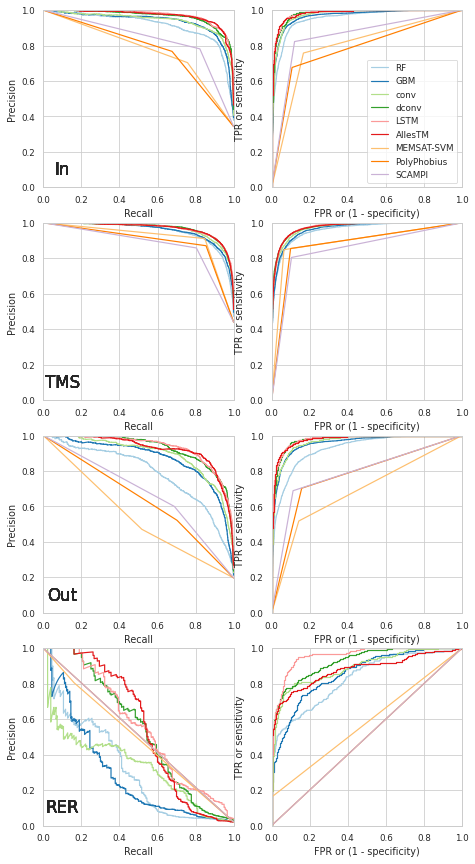

In [83]:
 plots_cat(zcoords_cat, {"cat": zcoords_cat}, num_classes=4, filename='zcoords_cat', class_names=['In', 'TMS', 'Out', 'RER'])

<h1>Phi angles</h2>

<h2>Phi angles continuous</h2>

In [84]:
phi_cont = pd.read_sql_query(f"select * from mllib_features_continuous_PhiAngles join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [85]:
phi_cont.groupby("experiment").describe()

resi                                            \
                              count        mean         std  min   25%    50%   
experiment                                                                      
anglor_phi                   9119.0  204.450707  155.431013  0.0  76.0  174.0   
blending_phi_IND_TEST        9119.0  204.450707  155.431013  0.0  76.0  174.0   
cnn_domain_angles_IND_TEST   9119.0  204.450707  155.431013  0.0  76.0  174.0   
dcnn_domain_angles_IND_TEST  9119.0  204.450707  155.431013  0.0  76.0  174.0   
lstm_domain_angles_IND_TEST  9119.0  204.450707  155.431013  0.0  76.0  174.0   
observed                     9119.0  204.450707  155.431013  0.0  76.0  174.0   
rf_phi_IND_TEST              9119.0  204.450707  155.431013  0.0  76.0  174.0   
spinex_phi                   9119.0  204.450707  155.431013  0.0  76.0  174.0   
spot1d_phi                   9119.0  204.450707  155.431013  0.0  76.0  174.0   
xgb_phi_IND_TEST             9119.0  204.450707  155.431013  0.0  76.0  174.0   

                                            val_0                        \
                               75%    max   count       mean        std   
experiment                                                                
anglor_phi                   303.0  746.0  9119.0 -66.661465  25.479493   
blending_phi_IND_TEST        303.0  746.0  9119.0 -67.886652  22.645479   
cnn_domain_angles_IND_TEST   303.0  746.0  9119.0 -67.197750  23.577925   
dcnn_domain_angles_IND_TEST  303.0  746.0  9119.0 -66.695544  23.438048   
lstm_domain_angles_IND_TEST  303.0  746.0  9119.0 -66.765858  24.798872   
observed                     303.0  746.0  9119.0 -66.609733  38.517392   
rf_phi_IND_TEST              303.0  746.0  9119.0 -67.987223  19.401911   
spinex_phi                   303.0  746.0  9119.0 -70.252988  31.772793   
spot1d_phi                   303.0  746.0  9119.0 -68.350916  32.699434   
xgb_phi_IND_TEST             303.0  746.0  9119.0 -67.370598  19.901514   

                                                                          \
                                    min        25%        50%        75%   
experiment                                                                 
anglor_phi                  -114.000000 -74.500000 -65.000000 -62.500000   
blending_phi_IND_TEST       -126.144796 -76.039278 -67.039128 -63.859223   
cnn_domain_angles_IND_TEST  -139.632162 -75.014351 -65.005619 -62.471070   
dcnn_domain_angles_IND_TEST -137.505608 -72.834067 -64.365758 -62.869994   
lstm_domain_angles_IND_TEST -126.162986 -73.649045 -64.713433 -63.253777   
observed                    -179.421007 -77.397074 -65.546640 -58.178465   
rf_phi_IND_TEST             -114.125389 -76.239697 -69.521703 -65.096164   
spinex_phi                  -138.400000 -85.200000 -67.600000 -63.900000   
spot1d_phi                  -158.640000 -78.490000 -65.530000 -64.390000   
xgb_phi_IND_TEST            -120.471315 -75.927301 -68.040755 -63.371491   

                                         
                                    max  
experiment                               
anglor_phi                   180.000000  
blending_phi_IND_TEST         93.674453  
cnn_domain_angles_IND_TEST   104.100920  
dcnn_domain_angles_IND_TEST  107.380486  
lstm_domain_angles_IND_TEST  100.839468  
observed                     179.443630  
rf_phi_IND_TEST               68.533972  
spinex_phi                    98.800000  
spot1d_phi                   174.470000  
xgb_phi_IND_TEST              81.401769

<h3>Benchmark measures</h3>

In [86]:
measures_cont(phi_cont, filename='phi_cont')

,r,MAE,MSE,RMSE
RF,0.550000,18.910000,1039.180000,32.240000
GBM,0.570000,18.500000,1012.280000,31.820000
conv,0.590000,16.930000,970.280000,31.150000
dconv,0.560000,17.430000,1026.220000,32.030000
LSTM,0.570000,17.030000,1000.330000,31.630000
AllesTM,0.590000,17.340000,962.860000,31.030000
SPINE X,0.450000,20.680000,1409.310000,37.540000
ANGLOR,0.450000,19.570000,1246.150000,35.300000
SPOT-1D,0.620000,15.850000,1004.360000,31.690000


<h3>Benchmark plots</h3>

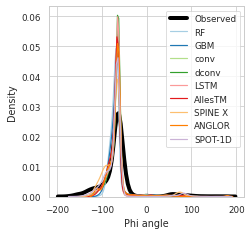

In [87]:
plots_cont(phi_cont, "Phi angle", "Density", filename='phi_cont')

<h1>Psi angles</h2>

<h2>Psi angles continuous</h2>

In [88]:
psi_cont = pd.read_sql_query(f"select * from mllib_features_continuous_PsiAngles join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [89]:
psi_cont.groupby("experiment").describe()

resi                                            \
                              count        mean         std  min   25%    50%   
experiment                                                                      
anglor_psi                   9119.0  204.450707  155.431013  0.0  76.0  174.0   
blending_psi_IND_TEST        9119.0  204.450707  155.431013  0.0  76.0  174.0   
cnn_domain_angles_IND_TEST   9119.0  204.450707  155.431013  0.0  76.0  174.0   
dcnn_domain_angles_IND_TEST  9119.0  204.450707  155.431013  0.0  76.0  174.0   
lstm_domain_angles_IND_TEST  9119.0  204.450707  155.431013  0.0  76.0  174.0   
observed                     9119.0  204.450707  155.431013  0.0  76.0  174.0   
rf_psi_IND_TEST              9119.0  204.450707  155.431013  0.0  76.0  174.0   
spinex_psi                   9119.0  204.450707  155.431013  0.0  76.0  174.0   
spot1d_psi                   9119.0  204.450707  155.431013  0.0  76.0  174.0   
xgb_psi_IND_TEST             9119.0  204.450707  155.431013  0.0  76.0  174.0   

                                            val_0                       \
                               75%    max   count      mean        std   
experiment                                                               
anglor_psi                   303.0  746.0  9119.0  1.732613  52.462271   
blending_psi_IND_TEST        303.0  746.0  9119.0 -5.174865  49.187134   
cnn_domain_angles_IND_TEST   303.0  746.0  9119.0 -7.525400  53.886089   
dcnn_domain_angles_IND_TEST  303.0  746.0  9119.0 -9.719050  51.637047   
lstm_domain_angles_IND_TEST  303.0  746.0  9119.0 -9.500979  53.261054   
observed                     303.0  746.0  9119.0 -6.383672  71.316589   
rf_psi_IND_TEST              303.0  746.0  9119.0 -3.469718  34.376076   
spinex_psi                   303.0  746.0  9119.0  4.396940  75.464249   
spot1d_psi                   303.0  746.0  9119.0 -3.995005  66.321725   
xgb_psi_IND_TEST             303.0  746.0  9119.0 -3.933983  41.324190   

                                                                          \
                                    min        25%        50%        75%   
experiment                                                                 
anglor_psi                  -172.800000 -36.350000 -18.800000  34.700000   
blending_psi_IND_TEST        -51.645657 -39.807236 -29.395803  12.737933   
cnn_domain_angles_IND_TEST   -54.160210 -41.755212 -37.043723   6.137263   
dcnn_domain_angles_IND_TEST  -47.691190 -42.093126 -38.085925   3.741819   
lstm_domain_angles_IND_TEST  -46.988074 -42.159646 -38.396574  -0.502664   
observed                    -179.965751 -45.996426 -37.053890  -3.045927   
rf_psi_IND_TEST              -47.754051 -32.830551 -12.756498  19.694431   
spinex_psi                  -180.000000 -40.000000 -34.000000  -0.900000   
spot1d_psi                  -178.560000 -41.690000 -39.140000  -3.030000   
xgb_psi_IND_TEST             -60.828820 -37.698635 -18.629890  20.840455   

                                         
                                    max  
experiment                               
anglor_psi                   180.000000  
blending_psi_IND_TEST        164.881778  
cnn_domain_angles_IND_TEST   167.571751  
dcnn_domain_angles_IND_TEST  168.607568  
lstm_domain_angles_IND_TEST  154.892554  
observed                     179.991139  
rf_psi_IND_TEST              121.296523  
spinex_psi                   179.900000  
spot1d_psi                   178.730000  
xgb_psi_IND_TEST             164.704308

<h3>Benchmark measures</h3>

In [90]:
measures_cont(psi_cont, filename='psi_cont')

,r,MAE,MSE,RMSE
RF,0.620000,39.500000,3228.610000,56.820000
GBM,0.660000,35.930000,2893.740000,53.790000
conv,0.700000,28.750000,2648.830000,51.470000
dconv,0.680000,29.470000,2740.610000,52.350000
LSTM,0.680000,28.810000,2762.240000,52.560000
AllesTM,0.700000,30.410000,2573.110000,50.730000
SPINE X,0.460000,41.770000,5991.920000,77.410000
ANGLOR,0.610000,38.330000,3350.110000,57.880000
SPOT-1D,0.740000,23.510000,2511.180000,50.110000


<h3>Benchmark plots</h3>

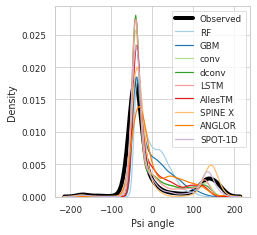

In [91]:
plots_cont(psi_cont, "Psi angle", "Density", filename='psi_cont')

In [92]:
#sns.kdeplot(phi_cont[phi_cont.experiment == 'observed'].val_0.values, psi_cont[psi_cont.experiment == 'observed'].val_0.values)

# Secondary structure

In [93]:
sec_cat = pd.read_sql_query(f"select * from mllib_features_categorical_SecStruc join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [94]:
sec_cat.groupby("experiment").describe()

resi                                            \
                        count        mean         std  min   25%    50%   
experiment                                                                
blending_sec_IND_TEST  9119.0  204.450707  155.431013  0.0  76.0  174.0   
cnn_sec_IND_TEST       9119.0  204.450707  155.431013  0.0  76.0  174.0   
dcnn_sec_IND_TEST      9119.0  204.450707  155.431013  0.0  76.0  174.0   
lstm_sec_IND_TEST      9119.0  204.450707  155.431013  0.0  76.0  174.0   
observed               9119.0  204.450707  155.431013  0.0  76.0  174.0   
prof                   9119.0  204.450707  155.431013  0.0  76.0  174.0   
psipred                9119.0  204.450707  155.431013  0.0  76.0  174.0   
rf_sec_IND_TEST        9119.0  204.450707  155.431013  0.0  76.0  174.0   
spinex_sec             9119.0  204.450707  155.431013  0.0  76.0  174.0   
spot1d_sec             9119.0  204.450707  155.431013  0.0  76.0  174.0   
xgb_sec_IND_TEST       9119.0  204.450707  155.431013  0.0  76.0  174.0   

                                      val_0             ...     val_1  \
                         75%    max   count       mean  ...       75%   
experiment                                              ...             
blending_sec_IND_TEST  303.0  746.0  9119.0   0.668317  ...  0.042877   
cnn_sec_IND_TEST       303.0  746.0  9119.0   0.651559  ...  0.030575   
dcnn_sec_IND_TEST      303.0  746.0  9119.0   0.673473  ...  0.022973   
lstm_sec_IND_TEST      303.0  746.0  9119.0   0.657259  ...  0.022019   
observed               303.0  746.0  9119.0   0.680009  ...  0.000000   
prof                   303.0  746.0  9119.0   0.612567  ...  0.000000   
psipred                303.0  746.0  9119.0   0.678254  ...  0.000000   
rf_sec_IND_TEST        303.0  746.0  9119.0   0.645460  ...  0.088144   
spinex_sec             303.0  746.0  9119.0   0.614692  ...  0.051850   
spot1d_sec             303.0  746.0  9119.0  67.346982  ...  1.020000   
xgb_sec_IND_TEST       303.0  746.0  9119.0   0.672780  ...  0.022879   

                                   val_2                                  \
                             max   count       mean        std       min   
experiment                                                                 
blending_sec_IND_TEST   0.952120  9119.0   0.271396   0.316488  0.026963   
cnn_sec_IND_TEST        0.997830  9119.0   0.287780   0.324639  0.000514   
dcnn_sec_IND_TEST       0.992417  9119.0   0.270689   0.320134  0.000567   
lstm_sec_IND_TEST       0.993746  9119.0   0.291282   0.318557  0.002505   
observed                1.000000  9119.0   0.267464   0.442660  0.000000   
prof                    1.000000  9119.0   0.301458   0.458917  0.000000   
psipred                 1.000000  9119.0   0.283255   0.450604  0.000000   
rf_sec_IND_TEST         0.679949  9119.0   0.287044   0.242593  0.000000   
spinex_sec              0.935300  9119.0   0.283324   0.327221  0.023400   
spot1d_sec             99.950000  9119.0  26.879267  34.344194  0.020000   
xgb_sec_IND_TEST        0.994888  9119.0   0.286163   0.337648  0.000566   

                                                                 
                            25%       50%        75%        max  
experiment                                                       
blending_sec_IND_TEST  0.033049  0.065313   0.554012   0.894887  
cnn_sec_IND_TEST       0.018253  0.106301   0.572399   0.996158  
dcnn_sec_IND_TEST      0.014174  0.085564   0.527231   0.991386  
lstm_sec_IND_TEST      0.020831  0.122463   0.565318   0.985250  
observed               0.000000  0.000000   1.000000   1.000000  
prof                   0.000000  0.000000   1.000000   1.000000  
psipred                0.000000  0.000000   1.000000   1.000000  
rf_sec_IND_TEST        0.071976  0.214968   0.477516   0.952435  
spinex_sec             0.032500  0.078300   0.572450   0.936400  
spot1d_sec             0.740000  6.430000  52.445000  99.980000  
xgb_sec_IND_TEST       0.013

<h3>Benchmark measures</h3>

In [95]:
measures_cat(sec_cat, 3, class_names=['H', 'E', 'C'], filename='sec_cat')

,ACC,H (P),H (R),H (F1),H (AUC),H (MCC),E (P),E (R),E (F1),E (AUC),E (MCC),C (P),C (R),C (F1),C (AUC),C (MCC)
RF,0.820000,0.860000,0.900000,0.880000,0.800000,0.620000,0.970000,0.230000,0.370000,0.620000,0.460000,0.690000,0.720000,0.700000,0.800000,0.590000
GBM,0.840000,0.900000,0.900000,0.900000,0.840000,0.680000,0.910000,0.460000,0.610000,0.730000,0.640000,0.700000,0.770000,0.730000,0.820000,0.630000
conv,0.850000,0.920000,0.900000,0.910000,0.870000,0.720000,0.770000,0.620000,0.680000,0.800000,0.670000,0.710000,0.790000,0.750000,0.840000,0.650000
dconv,0.850000,0.900000,0.910000,0.910000,0.850000,0.710000,0.770000,0.610000,0.680000,0.800000,0.670000,0.730000,0.740000,0.740000,0.820000,0.640000
LSTM,0.850000,0.920000,0.900000,0.910000,0.860000,0.720000,0.810000,0.580000,0.670000,0.790000,0.670000,0.720000,0.790000,0.750000,0.840000,0.650000
AllesTM,0.860000,0.910000,0.910000,0.910000,0.860000,0.720000,0.770000,0.620000,0.690000,0.800000,0.680000,0.730000,0.760000,0.740000,0.830000,0.650000
SPINE X,0.770000,0.880000,0.830000,0.850000,0.800000,0.570000,0.320000,0.470000,0.380000,0.710000,0.340000,0.650000,0.690000,0.670000,0.780000,0.550000
PROFphd,0.780000,0.910000,0.820000,0.860000,0.820000,0.610000,0.350000,0.570000,0.430000,0.760000,0.410000,0.650000,0.730000,0.690000,0.800000,0.570000
PSIPRED,0.870000,0.920000,0.920000,0.920000,0.880000,0.760000,0.820000,0.600000,0.690000,0.800000,0.690000,0.750000,0.790000,0.770000,0.850000,0.680000
SPOT-1D,0.890000,0.920000,0.940000,0.930000,0.890000,0.780000,0.860000,0.760000,0.810000,0.880000,0.800000,0.800000,0.780000,0.790000,0.860000,0.720000


<h3>Benchmark plots</h3>

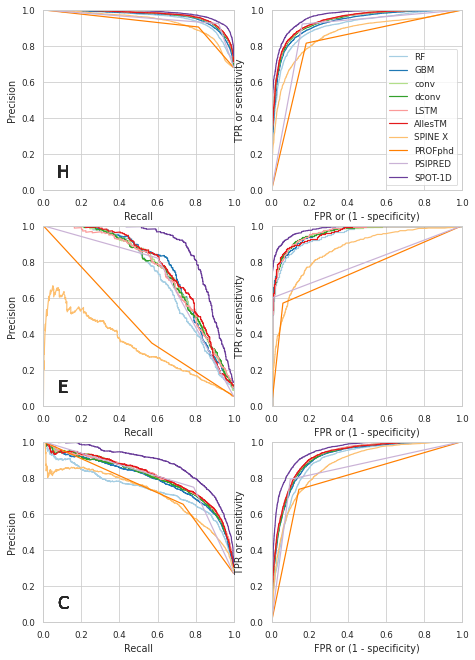

In [96]:
 plots_cat(sec_cat, {"cat": sec_cat}, filename='sec_cat', class_names=['H', 'E', 'C'])

# Secondary structure WITHOUT TMS

In [97]:
sec_cat_notms = pd.read_sql_query(f"select p.experiment, p.resi, p.val_0, p.val_1, p.val_2 from mllib_features_categorical_SecStruc as p join raw_data using (id, resi) join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where topo!='T' and topo !='R' and experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

In [98]:
#sec_cat_notms = pd.read_sql_query(f"select p.experiment, p.resi, p.val_0, p.val_1, p.val_2 from mllib_features_categorical_SecStruc as p join raw_data using (id, resi) join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where topo='T' and experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)


<h3>Data description</h3>

In [99]:
sec_cat_notms.groupby("experiment").describe()

resi                                            \
                        count        mean         std  min   25%    50%   
experiment                                                                
blending_sec_IND_TEST  4929.0  230.624873  165.915039  0.0  95.0  205.0   
cnn_sec_IND_TEST       4929.0  230.624873  165.915039  0.0  95.0  205.0   
dcnn_sec_IND_TEST      4929.0  230.624873  165.915039  0.0  95.0  205.0   
lstm_sec_IND_TEST      4929.0  230.624873  165.915039  0.0  95.0  205.0   
observed               4929.0  230.624873  165.915039  0.0  95.0  205.0   
prof                   4929.0  230.624873  165.915039  0.0  95.0  205.0   
psipred                4929.0  230.624873  165.915039  0.0  95.0  205.0   
rf_sec_IND_TEST        4929.0  230.624873  165.915039  0.0  95.0  205.0   
spinex_sec             4929.0  230.624873  165.915039  0.0  95.0  205.0   
spot1d_sec             4929.0  230.624873  165.915039  0.0  95.0  205.0   
xgb_sec_IND_TEST       4929.0  230.624873  165.915039  0.0  95.0  205.0   

                                      val_0             ...     val_1  \
                         75%    max   count       mean  ...       75%   
experiment                                              ...             
blending_sec_IND_TEST  339.0  746.0  4929.0   0.472137  ...  0.068367   
cnn_sec_IND_TEST       339.0  746.0  4929.0   0.447890  ...  0.074705   
dcnn_sec_IND_TEST      339.0  746.0  4929.0   0.476220  ...  0.063671   
lstm_sec_IND_TEST      339.0  746.0  4929.0   0.459475  ...  0.059815   
observed               339.0  746.0  4929.0   0.485494  ...  0.000000   
prof                   339.0  746.0  4929.0   0.426456  ...  0.000000   
psipred                339.0  746.0  4929.0   0.470075  ...  0.000000   
rf_sec_IND_TEST        339.0  746.0  4929.0   0.480951  ...  0.113451   
spinex_sec             339.0  746.0  4929.0   0.473378  ...  0.074700   
spot1d_sec             339.0  746.0  4929.0  48.292926  ...  3.740000   
xgb_sec_IND_TEST       339.0  746.0  4929.0   0.473158  ...  0.043520   

                                   val_2                                  \
                             max   count       mean        std       min   
experiment                                                                 
blending_sec_IND_TEST   0.952120  4929.0   0.423290   0.332893  0.028000   
cnn_sec_IND_TEST        0.997830  4929.0   0.446739   0.331846  0.000735   
dcnn_sec_IND_TEST       0.992417  4929.0   0.424376   0.331527  0.001109   
lstm_sec_IND_TEST       0.993746  4929.0   0.448988   0.321495  0.003060   
observed                1.000000  4929.0   0.420978   0.493766  0.000000   
prof                    1.000000  4929.0   0.479408   0.499626  0.000000   
psipred                 1.000000  4929.0   0.459931   0.498442  0.000000   
rf_sec_IND_TEST         0.679949  4929.0   0.422877   0.224568  0.013555   
spinex_sec              0.929800  4929.0   0.407648   0.349655  0.026000   
spot1d_sec             99.950000  4929.0  41.531840  36.843564  0.020000   
xgb_sec_IND_TEST        0.994888  4929.0   0.456886   0.344348  0.000999   

                                                                  
                            25%        50%        75%        max  
experiment                                                        
blending_sec_IND_TEST  0.069543   0.382660   0.783719   0.894887  
cnn_sec_IND_TEST       0.098885   0.443066   0.766339   0.996158  
dcnn_sec_IND_TEST      0.082395   0.400360   0.752534   0.991386  
lstm_sec_IND_TEST      0.116624   0.451733   0.756474   0.985250  
observed               0.000000   0.000000   1.000000   1.000000  
prof                   0.000000   0.000000   1.000000   1.000000  
psipred                0.000000   0.000000   1.000000   1.000000  
rf_sec_IND_TEST        0.228633   0.418415   0.604634   0.952435  
spinex_sec             0.053600   0.293100   0.807400   0.936400  
spot1d_sec             4.350000  32.210000  79.330000  99.980000  
xgb_sec_IND_TES

<h3>Benchmark measures</h3>

In [100]:
measures_cat(sec_cat_notms, 3, class_names=['H', 'E', 'C'], filename='sec_cat_notms')

,ACC,H (P),H (R),H (F1),H (AUC),H (MCC),E (P),E (R),E (F1),E (AUC),E (MCC),C (P),C (R),C (F1),C (AUC),C (MCC)
RF,0.730000,0.740000,0.780000,0.760000,0.760000,0.520000,0.970000,0.240000,0.390000,0.620000,0.470000,0.700000,0.780000,0.740000,0.770000,0.530000
GBM,0.770000,0.820000,0.770000,0.790000,0.800000,0.610000,0.920000,0.480000,0.630000,0.740000,0.640000,0.710000,0.830000,0.760000,0.790000,0.570000
conv,0.780000,0.860000,0.770000,0.810000,0.820000,0.650000,0.780000,0.640000,0.700000,0.810000,0.680000,0.720000,0.840000,0.770000,0.800000,0.590000
dconv,0.780000,0.820000,0.800000,0.810000,0.820000,0.640000,0.770000,0.630000,0.690000,0.810000,0.670000,0.730000,0.790000,0.760000,0.790000,0.580000
LSTM,0.780000,0.850000,0.780000,0.810000,0.820000,0.650000,0.810000,0.600000,0.690000,0.790000,0.670000,0.720000,0.830000,0.770000,0.800000,0.590000
AllesTM,0.790000,0.840000,0.800000,0.820000,0.830000,0.660000,0.770000,0.640000,0.700000,0.810000,0.680000,0.740000,0.810000,0.770000,0.800000,0.590000
SPINE X,0.720000,0.770000,0.760000,0.770000,0.780000,0.550000,0.500000,0.480000,0.490000,0.710000,0.440000,0.710000,0.720000,0.720000,0.750000,0.500000
PROFphd,0.730000,0.820000,0.720000,0.770000,0.780000,0.570000,0.570000,0.570000,0.570000,0.760000,0.520000,0.680000,0.770000,0.720000,0.750000,0.500000
PSIPRED,0.810000,0.870000,0.840000,0.850000,0.860000,0.720000,0.820000,0.620000,0.700000,0.800000,0.690000,0.760000,0.830000,0.790000,0.820000,0.630000
SPOT-1D,0.840000,0.860000,0.870000,0.860000,0.870000,0.740000,0.880000,0.780000,0.830000,0.880000,0.810000,0.810000,0.820000,0.810000,0.840000,0.670000


<h3>Benchmark plots</h3>

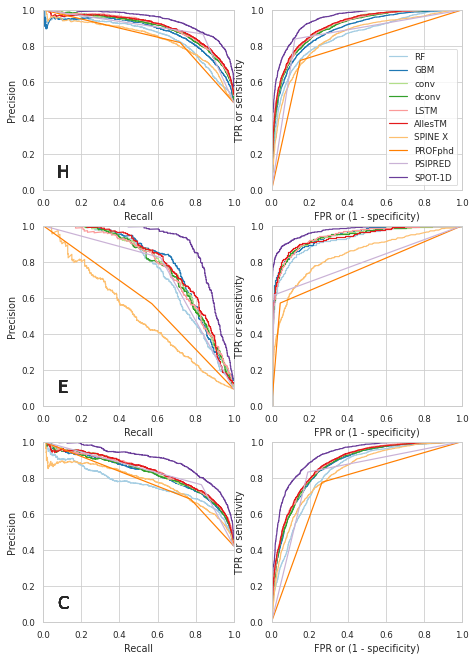

In [101]:
 plots_cat(sec_cat_notms, {"cat": sec_cat_notms}, filename='sec_cat_notms', class_names=['H', 'E', 'C'])

# RSA

<h2>RSA complex</h2>

In [102]:
rsa_comp_cont = pd.read_sql_query(f"select * from mllib_features_continuous_RsaComplex join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [103]:
rsa_comp_cont.groupby("experiment").describe()

resi                                     \
                                count        mean         std  min   25%   
experiment                                                                 
blending_rsa_complex_IND_TEST  9119.0  204.450707  155.431013  0.0  76.0   
cnn_domain_rsa_IND_TEST        9119.0  204.450707  155.431013  0.0  76.0   
dcnn_domain_rsa_IND_TEST       9119.0  204.450707  155.431013  0.0  76.0   
lstm_domain_rsa_IND_TEST       9119.0  204.450707  155.431013  0.0  76.0   
observed                       9119.0  204.450707  155.431013  0.0  76.0   
rf_rsa_complex_IND_TEST        9119.0  204.450707  155.431013  0.0  76.0   
spinex_rsa                     9119.0  204.450707  155.431013  0.0  76.0   
spot1d_rsa                     9119.0  204.450707  155.431013  0.0  76.0   
xgb_rsa_complex_IND_TEST       9119.0  204.450707  155.431013  0.0  76.0   

                                                     val_0            \
                                 50%    75%    max   count      mean   
experiment                                                             
blending_rsa_complex_IND_TEST  174.0  303.0  746.0  9119.0  0.265246   
cnn_domain_rsa_IND_TEST        174.0  303.0  746.0  9119.0  0.240040   
dcnn_domain_rsa_IND_TEST       174.0  303.0  746.0  9119.0  0.246077   
lstm_domain_rsa_IND_TEST       174.0  303.0  746.0  9119.0  0.238227   
observed                       174.0  303.0  746.0  9119.0  0.251038   
rf_rsa_complex_IND_TEST        174.0  303.0  746.0  9119.0  0.270309   
spinex_rsa                     174.0  303.0  746.0  9119.0  0.202402   
spot1d_rsa                     174.0  303.0  746.0  9119.0  0.305036   
xgb_rsa_complex_IND_TEST       174.0  303.0  746.0  9119.0  0.265800   

                                                                       \
                                    std       min       25%       50%   
experiment                                                              
blending_rsa_complex_IND_TEST  0.169433 -0.006684  0.115006  0.240473   
cnn_domain_rsa_IND_TEST        0.183721  0.000603  0.071533  0.211000   
dcnn_domain_rsa_IND_TEST       0.182199 -0.010676  0.081785  0.217915   
lstm_domain_rsa_IND_TEST       0.180527 -0.035773  0.075860  0.208411   
observed                       0.246289  0.000000  0.030488  0.176471   
rf_rsa_complex_IND_TEST        0.128175  0.019999  0.162551  0.255215   
spinex_rsa                     0.137878  0.009434  0.098780  0.163208   
spot1d_rsa                     0.193873  0.000952  0.131803  0.302941   
xgb_rsa_complex_IND_TEST       0.147661 -0.047219  0.141105  0.248572   

                                                   
                                    75%       max  
experiment                                         
blending_rsa_complex_IND_TEST  0.397891  0.887808  
cnn_domain_rsa_IND_TEST        0.381867  1.031382  
dcnn_domain_rsa_IND_TEST       0.386195  1.004587  
lstm_domain_rsa_IND_TEST       0.377645  0.981666  
observed                       0.419118  1.000000  
rf_rsa_complex_IND_TEST        0.372943  0.666718  
spinex_rsa                     0.277370  0.780986  
spot1d_rsa                     0.456331  0.916618  
xgb_rsa_complex_IND_TEST       0.381779  0.735714

<h3>Benchmark measures</h3>

In [104]:
measures_cont(rsa_comp_cont, filename='rsa_comp_cont')

,r,MAE,MSE,RMSE
RF,0.590000,0.160000,0.040000,0.200000
GBM,0.630000,0.150000,0.040000,0.190000
conv,0.630000,0.140000,0.040000,0.190000
dconv,0.640000,0.140000,0.040000,0.190000
LSTM,0.650000,0.140000,0.040000,0.190000
AllesTM,0.660000,0.140000,0.030000,0.190000
SPINE X,0.500000,0.170000,0.050000,0.220000
SPOT-1D,0.610000,0.160000,0.040000,0.210000


<h3>Benchmark plots</h3>

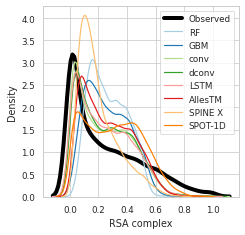

In [105]:
plots_cont(rsa_comp_cont, "RSA complex", "Density", filename='rsa_comp_cont')

# RSA chain

In [106]:
rsa_chain_cont = pd.read_sql_query(f"select * from mllib_features_continuous_RsaChain join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [107]:
rsa_chain_cont.groupby("experiment").describe()

resi                                            \
                              count        mean         std  min   25%    50%   
experiment                                                                      
blending_rsa_chain_IND_TEST  9119.0  204.450707  155.431013  0.0  76.0  174.0   
cnn_domain_rsa_IND_TEST      9119.0  204.450707  155.431013  0.0  76.0  174.0   
dcnn_domain_rsa_IND_TEST     9119.0  204.450707  155.431013  0.0  76.0  174.0   
lstm_domain_rsa_IND_TEST     9119.0  204.450707  155.431013  0.0  76.0  174.0   
observed                     9119.0  204.450707  155.431013  0.0  76.0  174.0   
rf_rsa_chain_IND_TEST        9119.0  204.450707  155.431013  0.0  76.0  174.0   
spinex_rsa                   9119.0  204.450707  155.431013  0.0  76.0  174.0   
spot1d_rsa                   9119.0  204.450707  155.431013  0.0  76.0  174.0   
xgb_rsa_chain_IND_TEST       9119.0  204.450707  155.431013  0.0  76.0  174.0   

                                            val_0                      \
                               75%    max   count      mean       std   
experiment                                                              
blending_rsa_chain_IND_TEST  303.0  746.0  9119.0  0.307951  0.174745   
cnn_domain_rsa_IND_TEST      303.0  746.0  9119.0  0.281208  0.192392   
dcnn_domain_rsa_IND_TEST     303.0  746.0  9119.0  0.287832  0.191078   
lstm_domain_rsa_IND_TEST     303.0  746.0  9119.0  0.281632  0.189134   
observed                     303.0  746.0  9119.0  0.323908  0.264468   
rf_rsa_chain_IND_TEST        303.0  746.0  9119.0  0.318431  0.121970   
spinex_rsa                   303.0  746.0  9119.0  0.202402  0.137878   
spot1d_rsa                   303.0  746.0  9119.0  0.305036  0.193873   
xgb_rsa_chain_IND_TEST       303.0  746.0  9119.0  0.314831  0.149507   

                                                                               
                                  min       25%       50%       75%       max  
experiment                                                                     
blending_rsa_chain_IND_TEST -0.022577  0.158858  0.299981  0.445264  0.929711  
cnn_domain_rsa_IND_TEST     -0.005108  0.105571  0.267743  0.433204  1.082910  
dcnn_domain_rsa_IND_TEST    -0.013665  0.117261  0.275516  0.435194  1.087819  
lstm_domain_rsa_IND_TEST    -0.042356  0.114263  0.267657  0.427261  1.001609  
observed                     0.000000  0.072165  0.294416  0.524390  1.000000  
rf_rsa_chain_IND_TEST        0.029666  0.222401  0.315449  0.414092  0.684437  
spinex_rsa                   0.009434  0.098780  0.163208  0.277370  0.780986  
spot1d_rsa                   0.000952  0.131803  0.302941  0.456331  0.916618  
xgb_rsa_chain_IND_TEST      -0.037285  0.195994  0.311381  0.431261  0.824328

<h3>Benchmark measures</h3>

In [108]:
measures_cont(rsa_chain_cont, filename='rsa_chain_cont')

,r,MAE,MSE,RMSE
RF,0.570000,0.180000,0.050000,0.220000
GBM,0.630000,0.170000,0.040000,0.210000
conv,0.610000,0.160000,0.050000,0.220000
dconv,0.650000,0.160000,0.040000,0.210000
LSTM,0.640000,0.160000,0.040000,0.210000
AllesTM,0.670000,0.150000,0.040000,0.200000
SPINE X,0.460000,0.200000,0.070000,0.260000
SPOT-1D,0.710000,0.140000,0.030000,0.190000


<h3>Benchmark plots</h3>

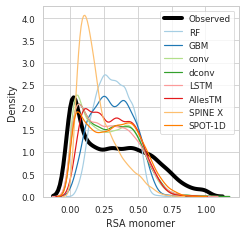

In [109]:
plots_cont(rsa_chain_cont, "RSA monomer", "Density", filename='rsa_chain_cont')

# RSA diff

In [110]:
rsa_diff_cont = pd.read_sql_query(f"select * from mllib_features_continuous_RsaDiff join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [111]:
rsa_diff_cont.groupby("experiment").describe()

resi                                            \
                             count        mean         std  min   25%    50%   
experiment                                                                     
blending_rsa_diff_IND_TEST  9119.0  204.450707  155.431013  0.0  76.0  174.0   
cnn_domain_rsa_IND_TEST     9119.0  204.450707  155.431013  0.0  76.0  174.0   
dcnn_domain_rsa_IND_TEST    9119.0  204.450707  155.431013  0.0  76.0  174.0   
lstm_domain_rsa_IND_TEST    9119.0  204.450707  155.431013  0.0  76.0  174.0   
observed                    9119.0  204.450707  155.431013  0.0  76.0  174.0   
rf_rsa_diff_IND_TEST        9119.0  204.450707  155.431013  0.0  76.0  174.0   
xgb_rsa_diff_IND_TEST       9119.0  204.450707  155.431013  0.0  76.0  174.0   

                                           val_0                      \
                              75%    max   count      mean       std   
experiment                                                             
blending_rsa_diff_IND_TEST  303.0  746.0  9119.0  0.044508  0.040946   
cnn_domain_rsa_IND_TEST     303.0  746.0  9119.0  0.000651  0.001626   
dcnn_domain_rsa_IND_TEST    303.0  746.0  9119.0  0.003513  0.007621   
lstm_domain_rsa_IND_TEST    303.0  746.0  9119.0  0.003007  0.008247   
observed                    303.0  746.0  9119.0  0.072869  0.155712   
rf_rsa_diff_IND_TEST        303.0  746.0  9119.0  0.053515  0.032748   
xgb_rsa_diff_IND_TEST       303.0  746.0  9119.0  0.051913  0.035666   

                                                                              
                                 min       25%       50%       75%       max  
experiment                                                                    
blending_rsa_diff_IND_TEST -0.021446  0.017308  0.032522  0.057946  0.434442  
cnn_domain_rsa_IND_TEST    -0.032009 -0.000309  0.000473  0.001388  0.030256  
dcnn_domain_rsa_IND_TEST   -0.012343 -0.000625  0.001870  0.004934  0.061310  
lstm_domain_rsa_IND_TEST   -0.005446  0.000216  0.000949  0.002167  0.119121  
observed                    0.000000  0.000000  0.000000  0.026102  1.000000  
rf_rsa_diff_IND_TEST        0.003355  0.028270  0.046784  0.072085  0.217334  
xgb_rsa_diff_IND_TEST      -0.001630  0.027893  0.042130  0.064586  0.357934

<h3>Benchmark measures</h3>

In [112]:
measures_cont(rsa_diff_cont, filename='rsa_diff_cont')

,r,MAE,MSE,RMSE
RF,0.320000,0.090000,0.020000,0.150000
GBM,0.330000,0.090000,0.020000,0.150000
conv,0.160000,0.070000,0.030000,0.170000
dconv,0.330000,0.070000,0.030000,0.170000
LSTM,0.220000,0.070000,0.030000,0.170000
AllesTM,0.390000,0.080000,0.020000,0.150000


<h3>Benchmark plots</h3>

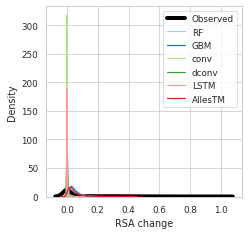

In [113]:
plots_cont(rsa_diff_cont, "RSA change", "Density", filename='rsa_diff_cont')

# Others

In [114]:
history = json.loads(conn.cursor().execute('select history from experiments where experiment="keras_all_targets" and fold=0').fetchone()[0])
history.keys()

TypeError: 'NoneType' object is not subscriptable

In [ ]:
plt.plot(range(len(history['loss'])), history['loss'])
plt.plot(range(len(history['val_loss'])), history['val_loss'])
plt.plot(range(len(history['lr'])), np.log(history['lr']) - np.min(np.log(history['lr'])))

In [ ]:
import sys
sys.path.append('..')

In [ ]:
from mllib.features.continuous import Pssm, Pssm2
from mllib.retrievers import SQLRetriever

In [ ]:
vals = []
vals2 = []
for idx in conn.cursor().execute('select id from alignments limit 20'):
    print(idx)
    #vals.extend(Pssm().transform(SQLRetriever(conn, Pssm.query).transform(idx[0])).flatten())
    #vals2.extend(Pssm2().transform(SQLRetriever(conn, Pssm.query).transform(idx[0])).flatten())
    
#msa = SQLRetriever(conn, Pssm.query).transform('1kpl_B')
#%time Pssm().transform(msa)

In [ ]:
len(vals), len(vals2)

In [ ]:
vals = np.array(vals)
vals2 = np.array(vals2)

In [ ]:
def normalize(xs):
    return list(map(lambda x: 1 / (1 + np.exp(-1 * x)), xs))
                
hist = True
kde = False
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.distplot(vals / 2 + 0.5, label='pssm', hist=hist, kde=kde, ax=axs[0])
sns.distplot(vals2, label='pssm2', hist=hist, kde=kde, ax=axs[1])
plt.legend()

In [ ]:
xxx = pd.read_sql_query('select phi, psi from raw_data', conn)

In [ ]:
xxx.describe()

In [ ]:
print(math.pi)